In [1]:
import pydicom
import open3d as o3d
import glob
import numpy as np
import copy

In [2]:
paths = glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/*.dcm")

In [12]:
pydicom.read_file(paths[0])

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.16
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.16
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223717.117369'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.4'
(0018, 5100) Patient Position                 

In [14]:
pcds = []

for path in paths:
    slice = pydicom.read_file(path)
    img = np.repeat(np.expand_dims(slice.pixel_array, -1), slice.SliceThickness, -1)
    pcd = o3d.geometry.PointCloud()
    x,y,z=np.where(img)
    
    index_voxel=np.vstack((x,y,z))
    grid_index_array=index_voxel.T
    pcd.points = o3d.utility.Vector3dVector(grid_index_array)
    colors = np.array([img[x,y,z] / 256 for x,y,z in grid_index_array]) 
    colors_rgb = np.stack([colors, colors, colors], axis=1)
    pcd.colors = o3d.utility.Vector3dVector(colors_rgb)
    
    d = slice.PixelSpacing

    X = np.array(list(slice.ImageOrientationPatient[:3]) + [0]) * d[0]
    Y = np.array(list(slice.ImageOrientationPatient[3:]) + [0]) * d[1]
    S = np.array(list(slice.ImagePositionPatient) + [1])
    
    transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
    
    transformed = pcd.transform(transform_matrix)
    pcds.append(copy.deepcopy(transformed))

In [15]:
o3d.visualization.draw_geometries(pcds)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [16]:
pcd_overall = o3d.geometry.PointCloud()
for pcd in pcds:
    pcd_overall.points.extend(pcd.points)
    pcd_overall.colors.extend(pcd.colors)

In [17]:
o3d.visualization.draw_geometries([pcd_overall])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [18]:
voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, d[0])
o3d.visualization.draw_geometries([voxel_grid])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [19]:
voxels = voxel_grid.get_voxels()

In [25]:
voxels[0]

Voxel with grid_index: (75, 160, 213), color: (0.125, 0.125, 0.125)

In [27]:
coords, vals = (np.array([voxel.grid_index for voxel in voxels]), 
                 np.array([voxel.color[0] for voxel in voxels]))


In [34]:
size = np.max(coords, axis=0) + 40
grid = np.zeros(size)

for index, coord in enumerate(coords):
    grid[coord] = vals[index] 

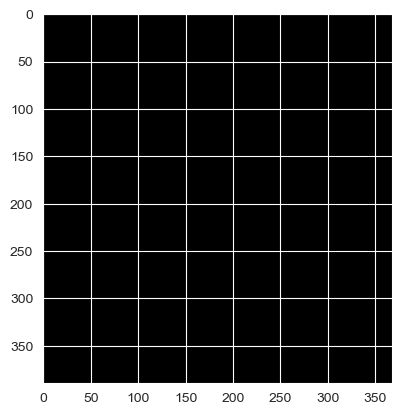

In [50]:
import matplotlib.pyplot as plt
plt.imshow(grid[61,:,:], cmap="gray")
plt.show()